In [3]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd

import optuna
from optuna.visualization import plot_contour

import shap

from lightgbm import LGBMRegressor

from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import numpy as np

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

import joblib

In [5]:
X_train = pd.read_csv('data/train.csv', dtype={'Class': bool})

In [6]:
features = [
        'ship_mode', 
        'segment',
        'region', 
        'category', 
        'sub_category', 
        'sales', 
        'quantity', 
        'discount',
        'state'
]

target = 'profit'

In [7]:
for feature in X_train.select_dtypes(include=['object','category']).columns.tolist():
    X_train[feature] = pd.Categorical(X_train[feature], categories=X_train[feature].unique())

In [8]:
y_train = X_train[target]
X_train = X_train[X_train.columns.drop(target)]
X_train = X_train[features]

In [9]:
X_train.dtypes

ship_mode       category
segment         category
region          category
category        category
sub_category    category
sales            float64
quantity           int64
discount         float64
state           category
dtype: object

## LightGBM

In [7]:
def objective(trial, X, y):

    param_grid = {
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 1),
        "max_depth": trial.suggest_int("max_depth", 5, 20), 
        'n_estimators': trial.suggest_int("n_estimators", 500, 1000), 
        'num_leaves': trial.suggest_int("num_leaves", 10, 50)
    }

    model = LGBMRegressor(
        boosting_type='gbdt',
        random_state=42,
        verbose=-1,
        **param_grid
    ) 
    
    def custom_scoring(estimator, X, y):
        y_pred = estimator.predict(X)
        return np.sqrt(mean_squared_error(y, y_pred))

    scores = cross_val_score(model, X, y, scoring=custom_scoring, 
                             cv=KFold(n_splits=5, shuffle=True, random_state=42),
                             error_score='raise')
    score = scores.mean() 

    return score


In [8]:
study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")
func = lambda trial: objective(trial, X_train, y_train)
study.optimize(func, n_trials=30)

[I 2024-03-04 21:37:18,896] A new study created in memory with name: LGBM Regressor
[I 2024-03-04 21:37:21,760] Trial 0 finished with value: 134.05399887663853 and parameters: {'learning_rate': 0.42982924450621474, 'max_depth': 12, 'n_estimators': 737, 'num_leaves': 27}. Best is trial 0 with value: 134.05399887663853.
[I 2024-03-04 21:37:23,402] Trial 1 finished with value: 132.6545302665512 and parameters: {'learning_rate': 0.04147831890607799, 'max_depth': 7, 'n_estimators': 544, 'num_leaves': 50}. Best is trial 1 with value: 132.6545302665512.
[I 2024-03-04 21:37:24,635] Trial 2 finished with value: 128.22757789390886 and parameters: {'learning_rate': 0.05386485933583992, 'max_depth': 6, 'n_estimators': 621, 'num_leaves': 13}. Best is trial 2 with value: 128.22757789390886.
[I 2024-03-04 21:37:26,772] Trial 3 finished with value: 133.24918628437987 and parameters: {'learning_rate': 0.10833634336152707, 'max_depth': 11, 'n_estimators': 534, 'num_leaves': 33}. Best is trial 2 with val

In [9]:
best_params = study.best_params

best_model = LGBMRegressor(
    boosting_type='gbdt',
    random_state=42,
    verbose=-1,
    **best_params
)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_train)

mse = np.sqrt(mean_squared_error(y_train, y_pred))

print("Erro Quadrático Médio:", mse)

Erro Quadrático Médio: 28.41843877059997


In [21]:
joblib.dump(best_model, f'models/best_model_lightgbm.pkl')

['models/best_model_lightgbm.pkl']

In [10]:
plot_contour(study)

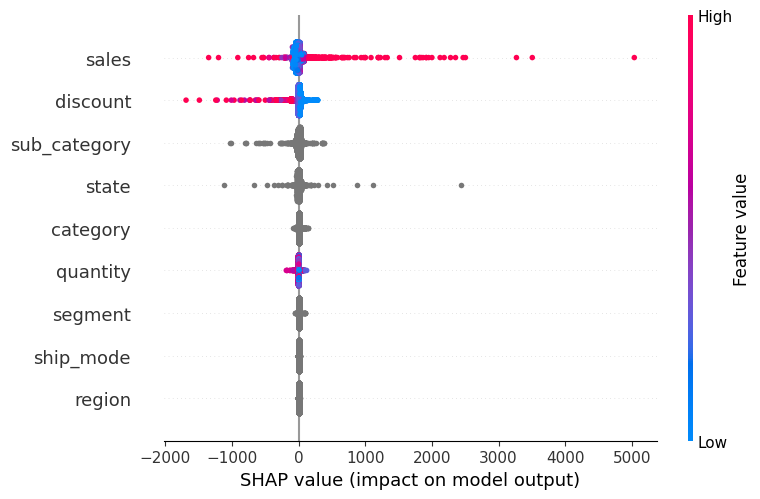

In [11]:
explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, show=False)

## Random Forest

In [12]:

def objective(trial, X, y):
    param_grid = {
        'n_estimators': trial.suggest_int("n_estimators", 100, 200), 
        'max_depth': trial.suggest_int("max_depth", 5, 20), 
        'min_samples_split': trial.suggest_int("min_samples_split", 2, 10), 
        'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 10)
    }

    categorical_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ],
        remainder='passthrough'
    )

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42, **param_grid))
    ])

    def custom_scoring(estimator, X, y):
        y_pred = estimator.predict(X)
        return np.sqrt(mean_squared_error(y, y_pred))

    scores = cross_val_score(model, X, y, scoring=custom_scoring, 
                             cv=KFold(n_splits=5, shuffle=True, random_state=42),
                             error_score='raise')
    score = scores.mean() 

    return score


In [13]:
study_rf = optuna.create_study(direction="minimize", study_name="RF Regressor")
func = lambda trial: objective(trial, X_train, y_train)
study_rf.optimize(func, n_trials=30)

[I 2024-03-04 21:39:07,558] A new study created in memory with name: RF Regressor
[I 2024-03-04 21:39:37,265] Trial 0 finished with value: 154.44974452730722 and parameters: {'n_estimators': 155, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 0 with value: 154.44974452730722.
[I 2024-03-04 21:39:45,827] Trial 1 finished with value: 150.59845375982937 and parameters: {'n_estimators': 155, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 150.59845375982937.
[I 2024-03-04 21:40:10,126] Trial 2 finished with value: 143.07358626896774 and parameters: {'n_estimators': 111, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 2 with value: 143.07358626896774.
[I 2024-03-04 21:40:30,388] Trial 3 finished with value: 159.52929139945275 and parameters: {'n_estimators': 125, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 10}. Best is trial 2 with value: 143.07358626896774.
[I 2024-0

In [22]:
best_params_rf = study_rf.best_params

categorical_cols = X_train.select_dtypes(include=['category', 'object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, **best_params_rf))
])

In [23]:
model.fit(X_train, y=y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ship_mode', 'segment',
                                                   'region', 'category',
                                                   'sub_category',
                                                   'state'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=9, min_samples_split=4,
                                       n_estimators=133, random_state=42))])

In [24]:
joblib.dump(model, f'models/best_model_randomforest.pkl')


['models/best_model_randomforest.pkl']

In [26]:
y_pred = model.predict(X_train)

mse = np.sqrt(mean_squared_error(y_train, y_pred))

print("Erro Quadrático Médio:", mse)

Erro Quadrático Médio: 55.572287165679036


## Gradient Boosting Regressor

In [29]:

def objective(trial, X, y):
    param_grid = {
        'learning_rate': trial.suggest_float("learning_rate", 0.001, 1),
        'n_estimators': trial.suggest_int("n_estimators", 500, 1000), 
        'max_depth': trial.suggest_int("max_depth", 3, 8), 
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'max_features': trial.suggest_categorical("max_features", ['sqrt', 'log2']),
    }

    categorical_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ],
        remainder='passthrough'
    )

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(random_state=42, **param_grid))
    ])

    def custom_scoring(estimator, X, y):
        y_pred = estimator.predict(X)
        return np.sqrt(mean_squared_error(y, y_pred))

    scores = cross_val_score(model, X, y, scoring=custom_scoring, 
                             cv=KFold(n_splits=5, shuffle=True, random_state=42),
                             error_score='raise')
    score = scores.mean() 

    return score


In [30]:
study_gbr = optuna.create_study(direction="minimize", study_name="GBR Regressor")
func = lambda trial: objective(trial, X_train, y_train)
study_gbr.optimize(func, n_trials=30)

[I 2024-03-04 21:57:27,152] A new study created in memory with name: GBR Regressor
[I 2024-03-04 21:57:34,365] Trial 0 finished with value: 152.38858219592868 and parameters: {'learning_rate': 0.5614389438869384, 'n_estimators': 531, 'max_depth': 8, 'subsample': 0.5419335930042032, 'max_features': 'sqrt'}. Best is trial 0 with value: 152.38858219592868.
[I 2024-03-04 21:57:40,178] Trial 1 finished with value: 117.18086208792127 and parameters: {'learning_rate': 0.03805170203940241, 'n_estimators': 709, 'max_depth': 6, 'subsample': 0.6317171555351655, 'max_features': 'log2'}. Best is trial 1 with value: 117.18086208792127.
[I 2024-03-04 21:57:46,069] Trial 2 finished with value: 184.29459744588016 and parameters: {'learning_rate': 0.8105564722898878, 'n_estimators': 510, 'max_depth': 7, 'subsample': 0.953770856886728, 'max_features': 'log2'}. Best is trial 1 with value: 117.18086208792127.
[I 2024-03-04 21:57:49,847] Trial 3 finished with value: 119.47287358047546 and parameters: {'lear

In [31]:
best_params_gbr = study_gbr.best_params

categorical_cols = X_train.select_dtypes(include=['category', 'object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

model_gbr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42, **best_params_gbr))
])

In [33]:
model_gbr.fit(X_train, y=y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ship_mode', 'segment',
                                                   'region', 'category',
                                                   'sub_category',
                                                   'state'])])),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.1217654005598485,
                                           max_depth=5, max_features='log2',
                                           n_estimators=768, random_state=42,
                                           subsample=0.636081296647839))])

In [34]:
joblib.dump(model_gbr, f'models/best_model_gbr.pkl')

['models/best_model_gbr.pkl']

In [35]:
y_pred = model_gbr.predict(X_train)

mse = np.sqrt(mean_squared_error(y_train, y_pred))

print("Erro Quadrático Médio:", mse)

Erro Quadrático Médio: 19.82340761372613


## KNR

In [10]:

def objective(trial, X, y):
    param_grid = {
        'n_neighbors': trial.suggest_int("n_neighbors", 3, 15),
        'weights': trial.suggest_categorical("weights", ['uniform', 'distance']),
        'p': trial.suggest_int("p", 1, 2),  # Manhattan (p=1) or Euclidean (p=2)
    }
    categorical_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ],
        remainder='passthrough'
    )

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor',KNeighborsRegressor(**param_grid))
    ])

    def custom_scoring(estimator, X, y):
        y_pred = estimator.predict(X)
        return np.sqrt(mean_squared_error(y, y_pred))

    scores = cross_val_score(model, X, y, scoring=custom_scoring, 
                             cv=KFold(n_splits=5, shuffle=True, random_state=42),
                             error_score='raise')
    score = scores.mean() 

    return score


In [11]:
study_knr = optuna.create_study(direction="minimize", study_name="KNR Regressor")
func = lambda trial: objective(trial, X_train, y_train)
study_knr.optimize(func, n_trials=30)

[I 2024-03-04 22:13:26,048] A new study created in memory with name: KNR Regressor
[I 2024-03-04 22:13:26,758] Trial 0 finished with value: 186.4311005319123 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 186.4311005319123.
[I 2024-03-04 22:13:27,358] Trial 1 finished with value: 163.3813807281482 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 163.3813807281482.
[I 2024-03-04 22:13:28,464] Trial 2 finished with value: 174.62252238261902 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 163.3813807281482.
[I 2024-03-04 22:13:29,074] Trial 3 finished with value: 171.1407403264344 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 163.3813807281482.
[I 2024-03-04 22:13:30,118] Trial 4 finished with value: 175.89577302845686 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'p': 2}. Best is trial 1

In [12]:
best_params_knr = study_knr.best_params

categorical_cols = X_train.select_dtypes(include=['category', 'object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

model_knr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(**best_params_knr))
])

In [13]:
model_knr.fit(X_train, y=y_train)
joblib.dump(model_knr, f'models/best_model_knr.pkl')


['models/best_model_knr.pkl']

In [15]:
y_pred = model_knr.predict(X_train)

mse = np.sqrt(mean_squared_error(y_train, y_pred))

print("Erro Quadrático Médio:", mse)

Erro Quadrático Médio: 1.034017196584682


## ExtraTrees

In [19]:

def objective(trial, X, y):
    param_grid = {
        'n_estimators': trial.suggest_int("n_estimators", 500, 1000), 
        'max_depth': trial.suggest_int("max_depth", 5, 20), 
        'min_samples_split': trial.suggest_int("min_samples_split", 2, 10), 
        'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 10),
        'max_features': trial.suggest_categorical("max_features", ['sqrt', 'log2']),
    }
    categorical_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ],
        remainder='passthrough'
    )

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor',ExtraTreesRegressor(random_state=42, **param_grid))
    ])

    def custom_scoring(estimator, X, y):
        y_pred = estimator.predict(X)
        return np.sqrt(mean_squared_error(y, y_pred))

    scores = cross_val_score(model, X, y, scoring=custom_scoring, 
                             cv=KFold(n_splits=5, shuffle=True, random_state=42),
                             error_score='raise')
    score = scores.mean() 

    return score


In [20]:
study_et = optuna.create_study(direction="minimize", study_name="ET Regressor")
func = lambda trial: objective(trial, X_train, y_train)
study_et.optimize(func, n_trials=30)

[I 2024-03-04 22:19:00,954] A new study created in memory with name: ET Regressor
[I 2024-03-04 22:19:06,087] Trial 0 finished with value: 189.45757814895538 and parameters: {'n_estimators': 688, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 189.45757814895538.
[I 2024-03-04 22:19:22,170] Trial 1 finished with value: 171.67643910695693 and parameters: {'n_estimators': 585, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 171.67643910695693.
[I 2024-03-04 22:19:33,255] Trial 2 finished with value: 178.3847688345182 and parameters: {'n_estimators': 888, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 171.67643910695693.
[I 2024-03-04 22:19:38,791] Trial 3 finished with value: 196.7528222628161 and parameters: {'n_estimators': 737, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_l

In [21]:
best_params_et = study_et.best_params

categorical_cols = X_train.select_dtypes(include=['category', 'object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

model_et = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ExtraTreesRegressor(random_state=42, **best_params_et))
])

In [22]:
model_et.fit(X_train, y=y_train)
joblib.dump(model_et, f'models/best_model_et.pkl')

['models/best_model_et.pkl']

In [23]:
y_pred = model_et.predict(X_train)

mse = np.sqrt(mean_squared_error(y_train, y_pred))

print("Erro Quadrático Médio:", mse)

Erro Quadrático Médio: 50.743084997961994
